In [147]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [170]:
#Create a function that will clean future data
def wrangle(filepath):
    df=pd.read_csv(filepath).set_index("PassengerId")
    #drop columns with > 50% null values
    df.drop(columns=["Cabin"],inplace=True)
    #drop high cardinality columns
    df.drop(columns=["Name","Ticket"],inplace=True)
    #drop irrelevant columns
    df.drop(columns="Embarked",inplace=True)
    return df

In [173]:
df=wrangle("/kaggle/input/titanic/train.csv")
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,0,3,male,22.0,1,0,7.2500
2,1,1,female,38.0,1,0,71.2833
3,1,3,female,26.0,0,0,7.9250
4,1,1,female,35.0,1,0,53.1000
5,0,3,male,35.0,0,0,8.0500


# ****Data Visualization****

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Number of passengers who survived
sns.countplot(x="Survived",data=df);
plt.xlabel("Survived")
plt.ylabel("Number of Passengers");

In [ ]:
#check the gender that survived the most
sns.countplot(x="Survived",hue="Sex",data=df)
plt.xlabel("Number of survivors in each gender")
plt.ylabel("Number of passengers");

In [ ]:
#Check number of survivors in each Pclass
sns.countplot(x="Survived",hue="Pclass",data=df);
plt.xlabel("Number of survivors in each Pclass")
plt.ylabel("Number of Passengers");

In [ ]:
#Check where most passengers embarked from
sns.countplot(x="Embarked",data=df)
plt.xlabel("Embarked Location")
plt.ylabel("Number of passengers");

In [ ]:
#Check the most common Pclass
sns.countplot(x="Pclass",data=df)
plt.xlabel("Passenger Class")
plt.ylabel("Number of passengers");

In [ ]:
#Check Age distribution
df["Age"].hist();

In [ ]:
#Check Fare distribution
df["Fare"].hist();

In [ ]:
sns.boxplot(x="Fare",data=df);

In [ ]:
#Number of survivors based on number of children per parent
sns.countplot(x="Survived",hue="Parch",data=df);
plt.xlabel("Number of Survivors based on Parent/Children")
plt.ylabel("Number of passengers");

In [ ]:
#Survival rate of Siblings/Spouses
sns.countplot(x="Survived",hue="SibSp",data=df);
plt.xlabel("Number of Survivors based on Sibling or spouses")
plt.ylabel("Number of passengers");

# *DATA SPLITTING*

In [ ]:
from sklearn.model_selection import train_test_split

In [174]:
X=df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y=df["Survived"]

In [175]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [176]:
Baseline=y_train.value_counts(normalize=True).max()
Baseline

0.6235955056179775

# ITERATE

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

In [177]:
model=make_pipeline(
    OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),
    SimpleImputer(strategy="mean"),
    DecisionTreeClassifier(random_state=42)
)

In [178]:
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [180]:
model.score(X_val,y_val)

0.7206703910614525

# MODEL TUNING

In [179]:
tree_depth=model.named_steps["decisiontreeclassifier"].get_depth()
tree_depth

23

In [181]:
hyper_params=range(1,23)

In [182]:
training_acc=[]
val_acc=[]
for x in hyper_params:
    model=make_pipeline(
        OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),
        SimpleImputer(strategy="mean"),
        DecisionTreeClassifier(max_depth=x,random_state=42)
    )
    model.fit(X_train,y_train)
    training_acc.append(model.score(X_train,y_train))
    val_acc.append(model.score(X_val,y_val))

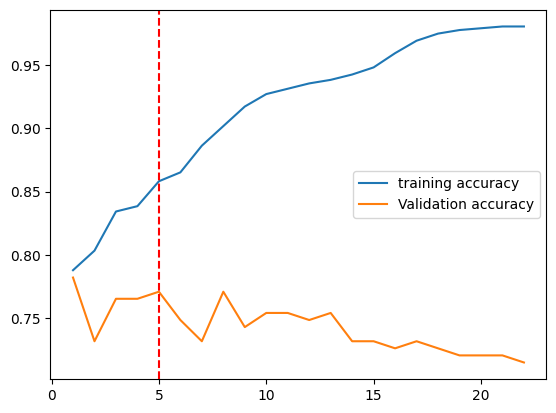

In [184]:
plt.plot(hyper_params,training_acc,label="training accuracy")
plt.plot(hyper_params,val_acc,label="Validation accuracy")
plt.legend();
plt.axvline(x=5,linestyle="--",color="red")

In [185]:
final_model=make_pipeline(
    OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),
    SimpleImputer(strategy="mean"),
    DecisionTreeClassifier(max_depth=5,random_state=42)
)
final_model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [186]:
final_model.score(X_train,y_train)

0.8581460674157303

In [187]:
final_model.score(X_val,y_val)

0.770949720670391

# PREDICTION

In [188]:
X_test=wrangle("/kaggle/input/titanic/test.csv")

In [189]:
X_test

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
892,3,male,34.5,0,0,7.8292
893,3,female,47.0,1,0,7.0000
894,2,male,62.0,0,0,9.6875
895,3,male,27.0,0,0,8.6625
896,3,female,22.0,1,1,12.2875
...,...,...,...,...,...,...
1305,3,male,NaN,0,0,8.0500
1306,1,female,39.0,0,0,108.9000
1307,3,male,38.5,0,0,7.2500


In [190]:
predictions=pd.DataFrame(final_model.predict(X_test),index=X_test.index)

In [191]:
predictions.head()


,0
PassengerId,
892,0
893,1
894,0
895,0
896,0


In [192]:
predictions.index.name="PassengerId"
predictions.columns=["Survived"]
predictions.to_csv("submission.csv")

In [193]:
d=pd.read_csv("submission.csv")

In [169]:
d.shape

(376, 2)